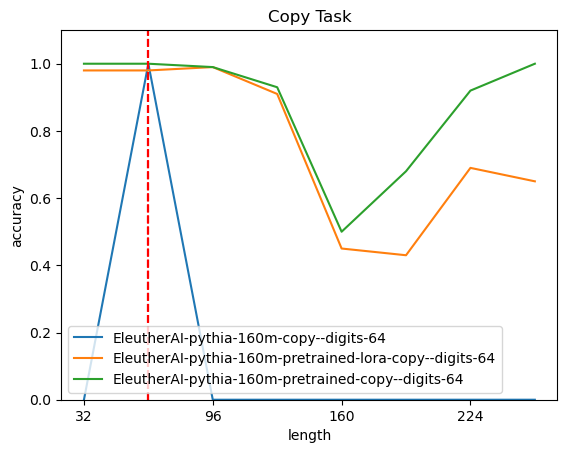

In [10]:
import wandb
import json

api = wandb.Api()
runs = api.runs('jackcai1206/mamba-arithmetic', filters={
    'config.model_id': 'EleutherAI/pythia-160m',
    'config.op': 'copy',
    'State': 'finished'
})[:3]

for run in runs:
    config = run.config
    lengths = range(config['n_digits_eval_start'], config['n_digits_eval_end'] + 1, config['n_digits_eval_step'])
    accs = []
    for l in lengths:
        accs.append(run.summary[f'eval/{l}_accuracy'])

    from matplotlib import pyplot as plt
    plt.plot(lengths, accs, label=config['run_name'])
    plt.vlines(config['n_digits_train'], 0, 1.1, linestyles='dashed', colors='r')
    plt.xticks(lengths[::2])
    plt.xlabel('length')
    plt.ylim(0, 1.1)
    plt.ylabel('accuracy')
plt.title('Copy Task')
plt.legend()


In [5]:
from datasets import IterableDataset
import itertools

def func():
    for i in range(10):
        yield i


ds = IterableDataset.from_generator(func)

for example in itertools.islice(ds, 0, 10):
    print(example)


0
1
2
3
4
5
6
7
8
9


{'_runtime': 32326.707334280018, '_step': 2949, '_timestamp': 1724825629.1533692, '_wandb': {'runtime': 32326}, 'eval/12-add-reverse-carry-only_accuracy': 1, 'eval/12-add-reverse-carry-only_distance': 1, 'eval/12-add-reverse-carry-only_runtime': 0.7897, 'eval/12-add-reverse-carry-only_samples_per_second': 126.629, 'eval/12-add-reverse-carry-only_steps_per_second': 1.266, 'eval/12-add-reverse-no-carry_accuracy': 1, 'eval/12-add-reverse-no-carry_distance': 1, 'eval/12-add-reverse-no-carry_runtime': 0.777, 'eval/12-add-reverse-no-carry_samples_per_second': 128.696, 'eval/12-add-reverse-no-carry_steps_per_second': 1.287, 'eval/12-add-reverse_accuracy': 1, 'eval/12-add-reverse_distance': 1, 'eval/12-add-reverse_runtime': 0.7926, 'eval/12-add-reverse_samples_per_second': 126.161, 'eval/12-add-reverse_steps_per_second': 1.262, 'eval/16-add-reverse-carry-only_accuracy': 1, 'eval/16-add-reverse-carry-only_distance': 1, 'eval/16-add-reverse-carry-only_runtime': 0.8174, 'eval/16-add-reverse-carry

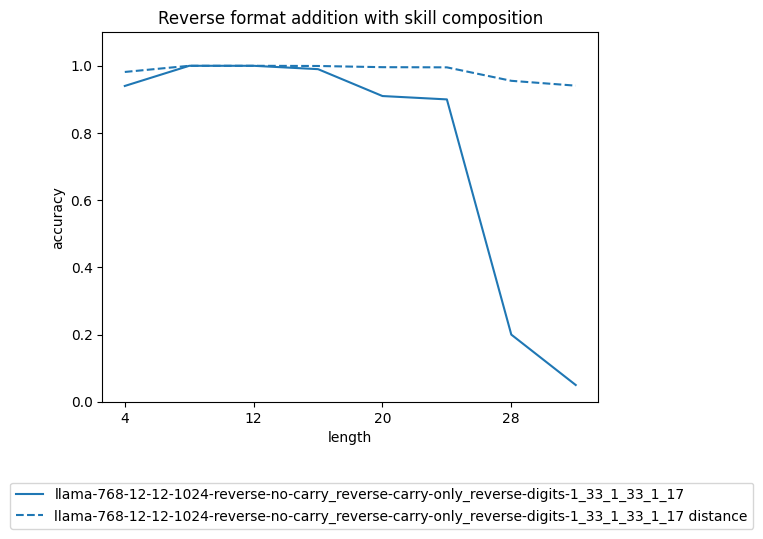

In [12]:
import wandb
import json
import seaborn as sns

api = wandb.Api()
runs = api.runs('jackcai1206/mamba-arithmetic', filters={
    'name': {'$in': ['xvvj9lxa']},
})[:2]

for ri, run in enumerate(runs):
    config = run.config
    lengths = range(*config['n_digits_eval'])
    accs = []
    dists = []
    print(run.summary)
    for l in lengths:
        accs.append(run.summary[f'eval/{l}-add-reverse_accuracy'])
        dists.append(run.summary[f'eval/{l}-add-reverse_distance'])

    from matplotlib import pyplot as plt
    plt.plot(lengths, accs, label=config['run_name'], color=sns.color_palette()[ri])
    plt.plot(lengths, dists, label=config['run_name'] + ' distance', linestyle='--', color=sns.color_palette()[ri])
    # plt.vlines(config['n_digits_train'][1], 0, 1.1, linestyles='dashed', colors='r')
    plt.xticks(lengths[::2])
    plt.xlabel('length')
    plt.ylim(0, 1.1)
    plt.ylabel('accuracy')
plt.title('Reverse format addition with skill composition')
plt.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2))